<a href="https://colab.research.google.com/github/MetronWard/hands_on_ml/blob/main/X_Ray_Pneumonia_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializing Kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

# Downloading Data

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force

100% 2.29G/2.29G [00:21<00:00, 75.8MB/s]
100% 2.29G/2.29G [00:22<00:00, 112MB/s] 


In [ ]:
from zipfile import ZipFile
ZIP_FILE_PATH = "/content/chest-xray-pneumonia.zip"
import os

def extract_data(filepath=ZIP_FILE_PATH):
  file = ZipFile(file=filepath)
  file.extractall()
  file.close()
  os.remove(filepath)

In [ ]:
extract_data()

In [ ]:
from pathlib import Path
import shutil

# Deleting excess folders

FOLDER_PATH = "/content/chest_xray"
for item in os.listdir(FOLDER_PATH):
  if item != "chest_xray":
    path = Path(FOLDER_PATH, item)
    shutil.rmtree(path)

# Visualizing Data

In [ ]:
from typing import Literal
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import random

FILEPATH = "/content/chest_xray/chest_xray/train"
TYPES = Literal["normal", "pneumonia"]
def plot_random_images(filepath=FILEPATH, types:TYPES="normal"):
  path = Path(filepath, types.upper())
  for folder_name, sub_folders, file_names in os.walk(path):
    choice = Path(path, random.choice(file_names))
  random_image = mimg.imread(choice)
  plt.imshow(random_image, cmap=plt.cm.binary_r)
  plt.title(types)
  plt.axis(False)
  print(f"The image has dimensions {random_image.shape}\n\n")

The image has dimensions (1329, 1882)




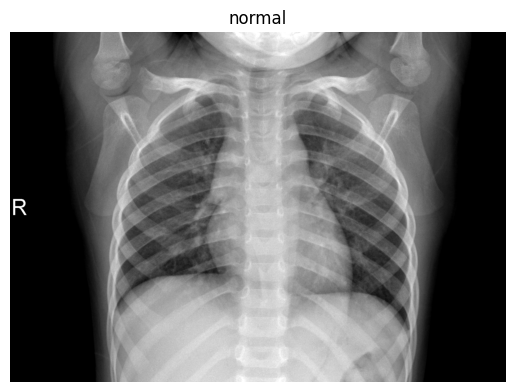

In [ ]:
plot_random_images(types="normal")

The image has dimensions (984, 1080)




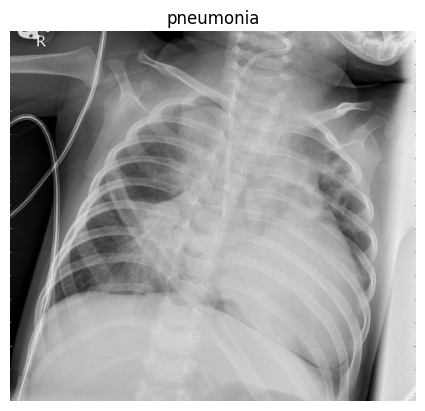

In [ ]:
plot_random_images(types="pneumonia")

# Developing a simple model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import Adam

## Data Generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir = "/content/chest_xray/chest_xray/train"
test_dir = "/content/chest_xray/chest_xray/test"
val_dir = "/content/chest_xray/chest_xray/val"

train_data = train_datagen.flow_from_directory(train_dir, batch_size=32,
                                               target_size=(224, 224), class_mode="binary",
                                               seed=42)

test_data = train_datagen.flow_from_directory(test_dir, batch_size=32,
                                               target_size=(224, 224), class_mode="binary",
                                               seed=42)

val_data = train_datagen.flow_from_directory(val_dir, batch_size=32,
                                               target_size=(224, 224), class_mode="binary",
                                               seed=42)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Baseline Model

In [ ]:
base_model = Sequential([
  Conv2D(filters=10,kernel_size=2,strides=1,
         padding="valid", activation="relu",
         input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(pool_size=3, padding="valid"),
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(pool_size=3, padding="valid"),
  Flatten(),
  Dense(1, activation="sigmoid")
])

In [ ]:
base_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 223, 223, 10)      130       
                                                                 
 conv2d_21 (Conv2D)          (None, 221, 221, 10)      910       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 73, 73, 10)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 71, 71, 10)        910       
                                                                 
 conv2d_23 (Conv2D)          (None, 69, 69, 10)        910       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 23, 23, 10)        0         
 ng2D)                                                

In [ ]:
base_model.compile(loss=keras.losses.BinaryCrossentropy(),
                   optimizer=Adam(),
                   metrics=["accuracy"])

base_history = base_model.fit(train_data, epochs=4, steps_per_epoch=len(train_data),
               validation_data = val_data, validation_steps=len(val_data), verbose=0)

## Visualizing Progress

In [ ]:
import pandas as pd
def plot_my_progress(history):
  df = pd.DataFrame(history.history)
  loss = df["loss"]
  val_loss = df["val_loss"]

  accuracy = df["accuracy"]
  val_accuracy = df["val_accuracy"]

  epochs = range(1, len(val_loss)+1)

  plt.figure()
  plt.plot(epochs, loss, label="Training Loss")
  plt.plot(epochs, val_loss, label="Validation Loss")
  plt.title("Losses")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label="Training accuracy")
  plt.plot(epochs, val_accuracy, label="Validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

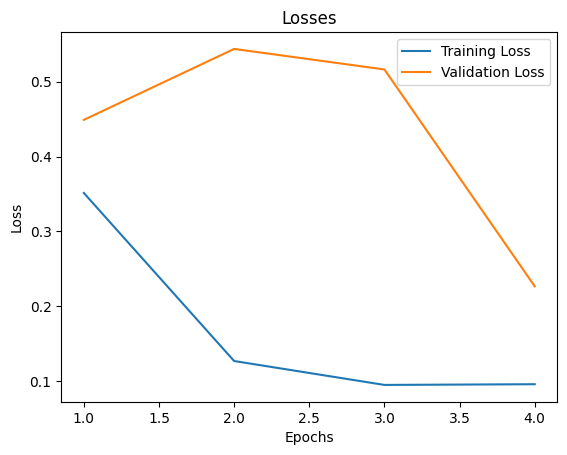

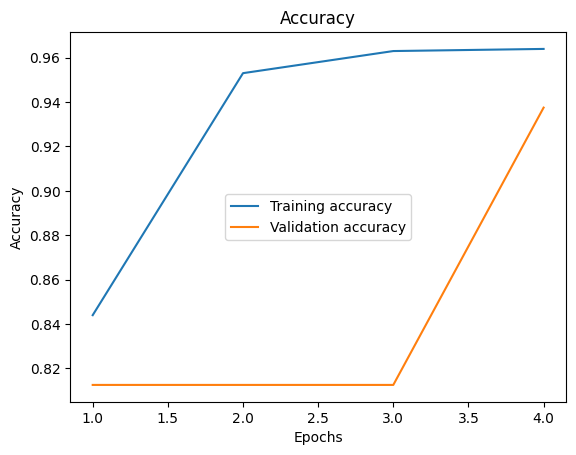

In [ ]:
plot_my_progress(base_history)

# Evualuation

In [ ]:
base_model.evaluate(test_data)

20/20 [==============================] - 6s 289ms/step - loss: 0.7252 - accuracy: 0.7804


[0.7252473831176758, 0.7804487347602844]

In [ ]:
# base_model.save("first_model.keras")

In [ ]:
def test_model_peformance(model=None, filepath:str=None, batchsize=224, class_names=["Normal", "Pneumonia"]):
  img = tf.io.read_file(filepath)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, [batchsize, batchsize])
  img = img/255.

  expanded_img = tf.expand_dims(img, axis=0)
  pred = int(tf.round(model.predict(expanded_img)))
  preds = class_names[pred]
  # return preds
  plt.imshow(img)
  plt.title(f"{preds}")
  plt.axis(False)

1/1 [==============================] - 0s 69ms/step


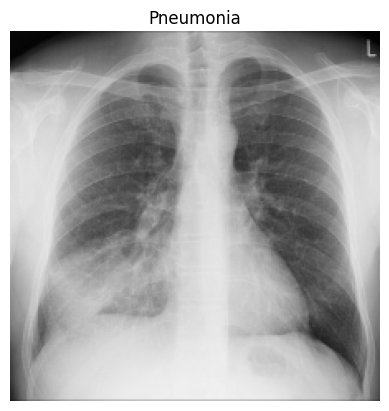

In [ ]:
test_model_peformance(model=base_model, filepath="/content/TEST.jpeg")

1/1 [==============================] - 0s 32ms/step


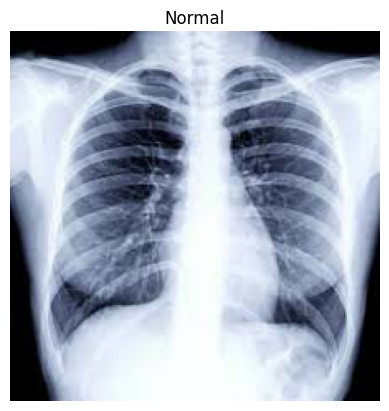

In [ ]:
test_model_peformance(model=base_model, filepath="/content/mine.jfif")